## Hospedagens em Recife
Nesta análise, exploramos a variação dos preços de hospedagem em Recife ao longo de um ano, com foco na identificação de padrões sazonais. Utilizamos técnicas estatísticas e visualizações para examinar como os preços variam entre os diferentes meses do ano. Esses insights são fundamentais para entender as dinâmicas do mercado hoteleiro e podem orientar estratégias de precificação e planejamento.

Os dados para esta análise foram obtidos do website booking.com utilizando a ferramenta Selenium. Coletamos informações como nomes, preços e detalhes de hospedagens para check-in de uma pessoa, com duração de 7 dias (o preço representando 7 diárias). Separamos os meses em 4 semanas cada um e assim extraímos os dados por cada check-in.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from fancyimpute import KNN
from scipy.stats import f_oneway, kruskal, shapiro
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
# carregando o dataset completo
hosp = pd.read_csv('dataset.csv', decimal=".")


## Definindo o tipo dos dados <a id="tipodosdados"></a>

Cidade e hotel vão virar atributos categóricos e checkin e checkout vão inicialmente ser colunas com o tipo data para conseguirmos operar adequadamente sobre eles

In [33]:
hosp['checkin'] = pd.to_datetime(hosp['checkin'])
hosp['checkout'] = pd.to_datetime(hosp['checkout'])
hosp['cidade'] = hosp["cidade"].astype("category")
hosp['hotel'] = hosp["hotel"].astype("category")
hosp['data_extracao'] = hosp["data_extracao"].astype("category")

In [34]:
# pegando do dataset apenas os dados até junho de 2025 para comparar um ano inteiro sem repetições
hospedagens = hosp[~((hosp['checkin'].dt.month > 6) & (hosp['checkin'].dt.year == 2025))]

In [35]:
# confirmando o tipo dos dados
hospedagens.dtypes

hotel                    category
cidade                   category
preço                       int64
checkin            datetime64[ns]
checkout           datetime64[ns]
dist_centro               float64
dist_praia                float64
avaliacao                 float64
qtnd_avaliacoes           float64
data_extracao            category
dtype: object

## Estatísticas Iniciais

In [36]:
# tamanho dos dados
hospedagens.shape

(15643, 10)

In [37]:
# visualizando as colunas 
hospedagens.columns

Index(['hotel', 'cidade', 'preço', 'checkin', 'checkout', 'dist_centro',
       'dist_praia', 'avaliacao', 'qtnd_avaliacoes', 'data_extracao'],
      dtype='object')

In [38]:
# uma breve descrição dos dados
hospedagens.describe()

,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes
count,15643.000000,15643,15643,15643.000000,11037.000000,12510.000000,12510.000000
mean,2091.195551,2024-11-15 05:30:06.328709120,2024-11-22 05:30:06.328709376,8.357665,0.580475,8.190392,448.566427
min,226.000000,2024-07-01 00:00:00,2024-07-08 00:00:00,0.200000,0.000000,1.000000,1.000000
25%,1188.000000,2024-08-22 00:00:00,2024-08-29 00:00:00,4.300000,0.100000,7.700000,3.000000
50%,1638.000000,2024-11-01 00:00:00,2024-11-08 00:00:00,6.800000,0.450000,8.600000,14.000000
75%,2270.000000,2025-01-22 00:00:00,2025-01-29 00:00:00,9.500000,0.750000,9.500000,96.000000
max,20793.000000,2025-06-22 00:00:00,2025-06-29 00:00:00,89.400000,3.000000,10.000000,8861.000000
std,1874.089123,NaN,NaN,7.928466,0.703904,1.935681,1156.761127


O desvio padrão gigantesco do preço chama a atenção juntamente com o máximo valor, indicando possíveis outliers, os quais podem distorcer a análise estatística e exigir uma investigação mais aprofundada para compreender sua origem

<Axes: >

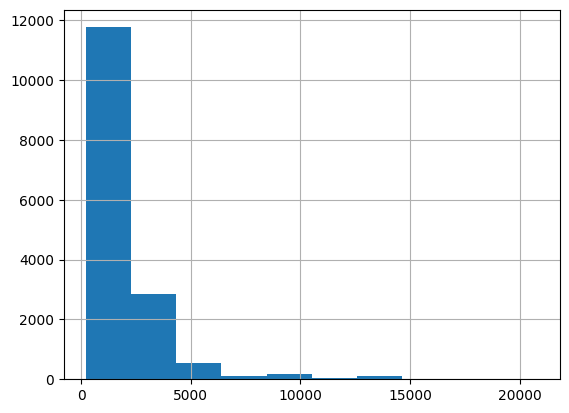

In [39]:
# hiistograma do preço das estadias
hospedagens['preço'].hist()

O histograma dos preços segue uma distribuição exponencial, indicando bastante outliers e que os dados são consideravelmente assimétricos. Potencialmente, aplicar o log10 sobre o preço pode minimizar os danos

<Axes: >

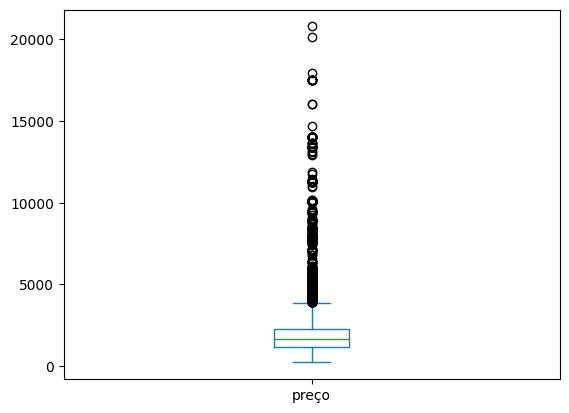

In [40]:
# plotando o boxplot dos dados
hospedagens['preço'].plot(kind='box')

O boxplot indica muitos outliers, como indicado anteriormente pelo desvio padrão alto e pelo histograma

### Estatísticas por Mês

Vamos agora printar estatísticas sobre o preço agrupado com o mês. Essas estatísticas podem revelar insights interessantes sobre o nosso objetivo principal (análise de variação dos preços e sazonalidade).

In [41]:
# agrupamos os dados por mês para entender a média dos preços de cada mês
preco_medio_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()
preco_medio_mensal

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\366261908.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_medio_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()


checkin
2024-07-31    1853.438967
2024-08-31    1852.081880
2024-09-30    1936.745310
2024-10-31    1977.388763
2024-11-30    2011.614892
2024-12-31    2269.954579
2025-01-31    2461.325480
2025-02-28    2248.170360
2025-03-31    2720.275000
2025-04-30    2325.341146
2025-05-31    2297.971154
2025-06-30    2122.087601
Freq: ME, Name: preço, dtype: float64

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\3941188951.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_medio_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()


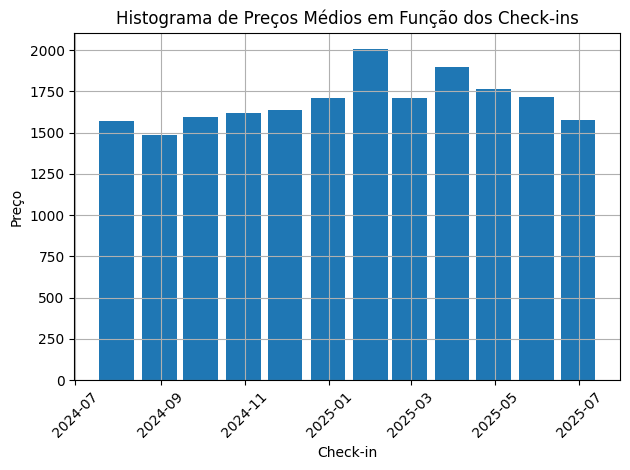

In [42]:
preco_medio_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()
plt.bar(preco_medio_mensal.index, preco_medio_mensal.values, width=25)
plt.xlabel('Check-in')
plt.ylabel('Preço')
plt.title('Histograma de Preços Médios em Função dos Check-ins')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Os preços médios traçados acima apresentam um pico em alguns pontos do período abordado, ressaltando principalmente os meses de janeiro e março, períodos que possuem épocas festivas interessantes, como o ano-novo e o carnaval. Isso sugere que essas são épocas mais procuradas pelos clientes e ,assim, o preço sobe

In [43]:
# agrupamos os dados por mês para entender a mediana dos preços de cada mês
preco_mediano_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()
preco_mediano_mensal

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\1934855314.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_mediano_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()


checkin
2024-07-31    1567.0
2024-08-31    1487.0
2024-09-30    1595.0
2024-10-31    1620.0
2024-11-30    1638.0
2024-12-31    1712.0
2025-01-31    2004.0
2025-02-28    1707.5
2025-03-31    1895.0
2025-04-30    1762.0
2025-05-31    1714.0
2025-06-30    1575.0
Freq: ME, Name: preço, dtype: float64

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\3836946410.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_mediano_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()


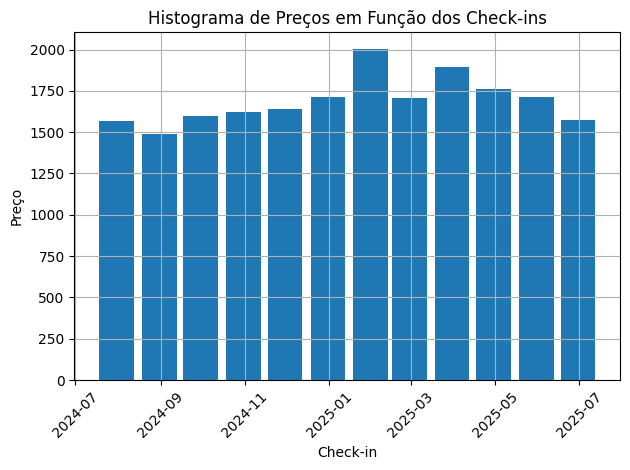

In [44]:
# Plotando o histograma dos preços por mês
preco_mediano_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()
plt.bar(preco_mediano_mensal.index, preco_mediano_mensal.values, width=25)
plt.xlabel('Check-in')
plt.ylabel('Preço')
plt.title('Histograma de Preços em Função dos Check-ins')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Os preços medianos mantém a mesma pegada da média, ressaltando os meses de janeiro e março como os mais cobiçados

Com a média e mediana dos dados, podemos ver que em alguns meses os valores são mais altos ou baixo, destacando uma provável variabilidade dos preços.

Agora vamos entender a distribuição do número de acomodações ao longo do tempo

In [45]:
# número de acomodações aparecendo por mês
num_hospedagens_mes = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].count()
num_hospedagens_mes

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\3033508448.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  num_hospedagens_mes = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].count()


checkin
2024-07-31    2130
2024-08-31    2064
2024-09-30    1759
2024-10-31    1762
2024-11-30    1719
2024-12-31    1343
2025-01-31    1146
2025-02-28     722
2025-03-31     760
2025-04-30     768
2025-05-31     728
2025-06-30     742
Freq: ME, Name: preço, dtype: int64

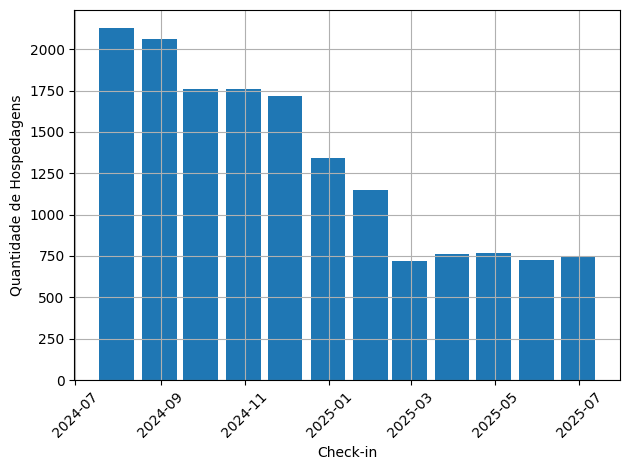

In [46]:
# Plotando o histograma da quantidade de hospedagens que apareceram cadastradas na booking por mês
plt.bar(num_hospedagens_mes.index, num_hospedagens_mes.values, width=25)
plt.xlabel('Check-in')
plt.ylabel('Quantidade de Hospedagens')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Aqui podemos perceber, que ao longo do tempo, o número de acomodações disponíveis para reserva vai caindo. O padrão demonstra que provavelmente uma boa parte dos hóteis, não fazem um cadastro para reserva tão antecipadamente. Com isso, cada mês se torna um grupo de análise diferente.

Agora vamos calcular o desvio padrão dos preços médios dos meses

In [47]:
# calculando o desvio padrão dos preços médios dos meses
preco_medio_mensal['price_change'] = preco_medio_mensal.std()
preco_medio_mensal['price_change']


145.65283418478546

Obtivemos um desvio padrão considerável, já esperado por conta dos plots anteriores. Esse desvio padrão ressalta que provavelmente há uma variação no preço entre os meses, o que pode indicar padrões sazonais

In [48]:
# criando uma coluna para armazenar o mês do checkin
# é interessante pois vamos analisar a sazonalidade dos dados
hospedagens['mes_checkin'] = hospedagens['checkin'].dt.month

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\2195187864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['mes_checkin'] = hospedagens['checkin'].dt.month


Em seguida vamos pegar apenas as hospedagens que aparecem em todos os check-ins do dataset. O objetivo é avaliar se os hóteis que aparacem em todas as datas possuem um viés claro (como preços mais elevados).

In [49]:
# Contar a quantidade de semanas distintas para cada hotel
hotel_week_count = hospedagens.groupby('hotel')['checkin'].nunique()

# Identificar o número máximo de semanas no período (52 semanas em um ano)
max_weeks = hospedagens['checkin'].nunique()

# Identificar os hotéis que aparecem em todas as semanas
hotels_all_weeks = hotel_week_count[hotel_week_count == max_weeks].index

# Filtrar o DataFrame para manter apenas os hotéis que aparecem em todas as semanas
hospedagens_filtered = hospedagens[hospedagens['hotel'].isin(hotels_all_weeks)]
hospedagens_filtered

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\413734298.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hotel_week_count = hospedagens.groupby('hotel')['checkin'].nunique()


,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
23,Flat em Boa Viagem,Recife,1190,2024-07-01,2024-07-08,9.4,0.1,7.4,1798.0,2024-6-6,7
24,Casa Recife Pousada,Recife,421,2024-07-01,2024-07-08,8.2,1.1,7.1,602.0,2024-6-6,7
27,Hotel Dan Inn Mar Piedade - Grande Recife,Recife,1953,2024-07-01,2024-07-08,13.7,0.0,7.8,2778.0,2024-6-6,7
33,Marante Plaza Hotel,Recife,3079,2024-07-01,2024-07-08,5.0,0.0,8.3,2420.0,2024-6-6,7
39,Flat em Boa Viagem,Recife,1070,2024-07-01,2024-07-08,9.3,0.1,7.4,461.0,2024-6-6,7
...,...,...,...,...,...,...,...,...,...,...,...
15634,flatpaivahome bugan paiva,Recife,1886,2025-06-22,2025-06-29,19.6,0.7,NaN,NaN,2024-6-6,6
15636,Apto a beira-mar em Jaboatao dos Guararapes PE,Recife,2050,2025-06-22,2025-06-29,19.4,0.6,9.0,2.0,2024-6-6,6
15637,Apt novíssimo Tamarineira,Recife,3780,2025-06-22,2025-06-29,4.1,NaN,10.0,4.0,2024-6-6,6
15638,Hostel da Socorro,Recife,2835,2025-06-22,2025-06-29,9.0,0.9,1.0,1.0,2024-6-6,6


In [50]:
# mediana dos preços das hospedagens que possuem o ambiente disponível em todos os checkins
hospedagens_filtered['preço'].median()

1714.0

In [51]:
# mediana dos preços do dataset completo
hospedagens['preço'].median()

1638.0

Podemos ver acima a mediana dos dados completos e a mediana dos dados que aparecem em todos os checkins. A diferença das medianas não parece ser tão significativa, então, preferimos por não optar pela imputação desses dados, já que essa iniciativa poderia modificar o principal fator de análise em questão.

In [52]:
hospedagens_filtered['preço'].std()

2982.846868705144

In [53]:
hospedagens['preço'].std()

1874.0891232783397

Diferença considerável no desvio padrão, provavelmente ocasionada pela menor consistência dos dados e bastante outliers.

Agora vamos plotar o histograma dos preços de cada mês

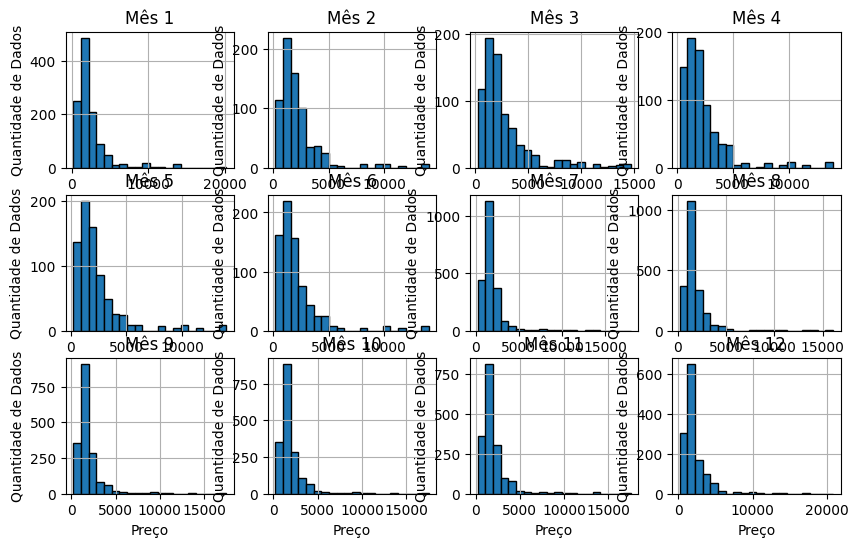

In [54]:
# Criar uma figura para os histogramas
plt.figure(figsize=(10, 6))

# Plotar histograma para cada mês
for month in range(1, 13):
    data_month = hospedagens[hospedagens['mes_checkin'] == month]
    plt.subplot(3, 4, month)
    plt.hist(data_month['preço'], bins=20, edgecolor='black')
    plt.title(f'Mês {month}')
    plt.xlabel('Preço')
    plt.ylabel('Quantidade de Dados')
    plt.grid(True)

Todos os meses apresentam uma distribuição exponencial, indicando que os dados são assimétricos e que possuem uma boa quantidade de outliers. Devemos reduzir essa assimetria para aplicar métodos de identificação de outliers e realizar testes de hipótese que suportem dados assimétricos

Plotando o boxplot de todos os meses para verificar a distribuição e outliers

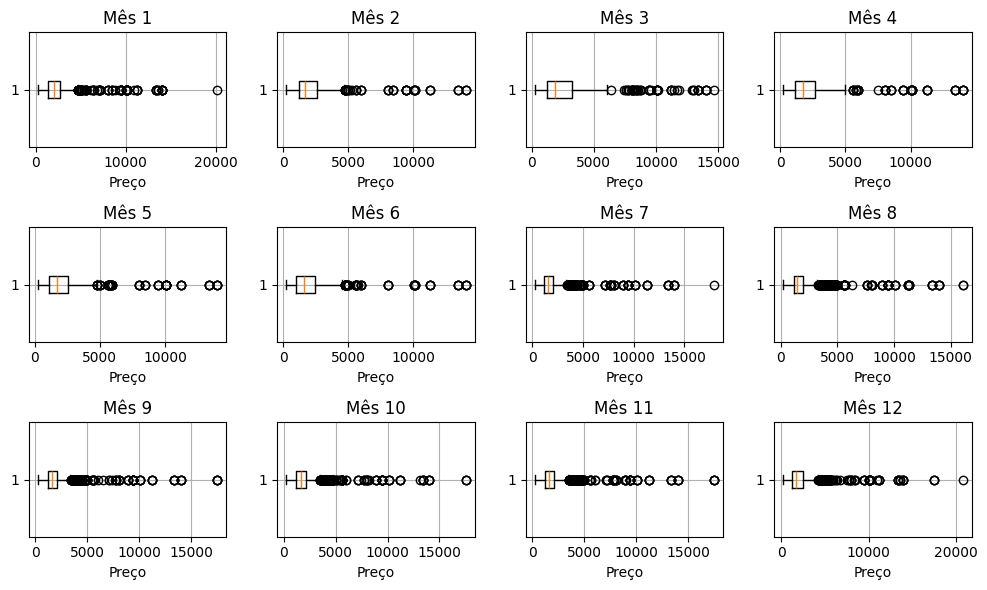

In [55]:
# Criar uma figura para os boxplots
plt.figure(figsize=(10, 6))

# Iterar sobre os meses e criar um boxplot para cada mês
for month in range(1, 13):
    data_month = hospedagens[hospedagens['mes_checkin'] == month]
    plt.subplot(3, 4, month)
    plt.boxplot(data_month['preço'], vert=False)
    plt.title(f'Mês {month}')
    plt.xlabel('Preço')
    plt.grid(True)

plt.tight_layout()
plt.show()

Todos os meses seguem o mesmo padrão, apresentando uma mediana enxuta se comparada aos maiores valores.

## Definindo dados faltantes

Primeiro vamos printar a quantidade de dados faltantes

In [56]:
# printando quantas linhas de cada coluna está faltante
print(hospedagens.isnull().sum())

hotel                 0
cidade                0
preço                 0
checkin               0
checkout              0
dist_centro           0
dist_praia         4606
avaliacao          3133
qtnd_avaliacoes    3133
data_extracao         0
mes_checkin           0
dtype: int64


3 colunas com uma quantidade até considerável de dados faltantes

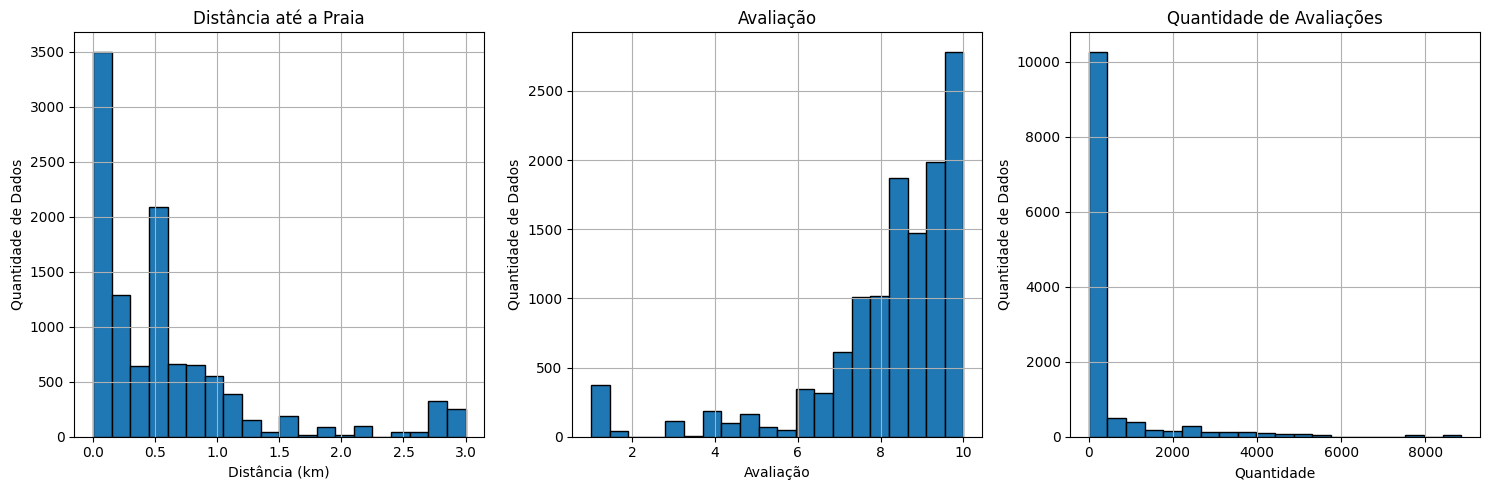

In [57]:
# Criar uma figura para os histogramas
plt.figure(figsize=(15, 5))

# Histograma para 'dist_praia'
plt.subplot(1, 3, 1)
plt.hist(hospedagens['dist_praia'], bins=20, edgecolor='black')
plt.title('Distância até a Praia')
plt.xlabel('Distância (km)')
plt.ylabel('Quantidade de Dados')
plt.grid(True)

# Histograma para 'avaliacao'
plt.subplot(1, 3, 2)
plt.hist(hospedagens['avaliacao'], bins=20, edgecolor='black')
plt.title('Avaliação')
plt.xlabel('Avaliação')
plt.ylabel('Quantidade de Dados')
plt.grid(True)

# Histograma para 'qtnd_avaliacoes'
plt.subplot(1, 3, 3)
plt.hist(hospedagens['qtnd_avaliacoes'], bins=20, edgecolor='black')
plt.title('Quantidade de Avaliações')
plt.xlabel('Quantidade')
plt.ylabel('Quantidade de Dados')
plt.grid(True)

plt.tight_layout()
plt.show()

Todas as colunas analisadas são assimétricas e apresentam uma quantidade considerável de dados faltantes.

Pegando um novo dataset e definindo o tipo dados para imputar os dados

In [58]:
# gerando um novo dataset a partir do csv com os dados e transformando os dados categóricos em numérico
hosp_input = pd.read_csv('dataset.csv', decimal=".")
hosp_input['checkin'] = pd.to_datetime(hosp_input['checkin'])
hosp_input['mes_checkin'] = hosp_input['checkin'].dt.month
hosp_input = hosp_input[~((hosp_input['checkin'].dt.month > 6) & (hosp_input['checkin'].dt.year == 2025))]
hosp_input['checkin'] = hosp_input['checkin'].astype("category")
hosp_input['checkout'] = hosp_input['checkout'].astype("category")
hosp_input['cidade'] = hosp_input["cidade"].astype("category")
hosp_input['hotel'] = hosp_input["hotel"].astype("category")
hosp_input['data_extracao'] =hosp_input["data_extracao"].astype("category")
hosp_input['hotel'] = hosp_input['hotel'].cat.codes
hosp_input['checkin'] = hosp_input['checkin'].cat.codes
hosp_input['checkout'] = hosp_input['checkout'].cat.codes
hosp_input['cidade'] = hosp_input['cidade'].cat.codes
hosp_input['data_extracao'] = hosp_input['data_extracao'].cat.codes
hosp_input.shape

(15643, 11)

Vamos ver a correlação dos dados para entender mais sobre a relação entre eles. Vamos usar spearman por termos dados não simétricos.

In [59]:
# entendendo a correlação dos dados a partir do método spearman (dados não simétricos)
hosp_input.corr(method="spearman")

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
hotel,1.000000,NaN,-0.045768,-0.013961,-0.013941,-0.052071,0.079522,-0.137409,0.130129,NaN,0.012697
cidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preço,-0.045768,NaN,1.000000,0.092607,0.092925,0.114370,-0.177471,0.127552,0.047562,NaN,-0.049790
checkin,-0.013961,NaN,0.092607,1.000000,0.988251,-0.014037,0.022954,0.018551,-0.071389,NaN,-0.298065
checkout,-0.013941,NaN,0.092925,0.988251,1.000000,-0.013602,0.022948,0.017814,-0.070567,NaN,-0.298065
dist_centro,-0.052071,NaN,0.114370,-0.014037,-0.013602,1.000000,-0.206097,-0.048546,0.147993,NaN,0.009141
dist_praia,0.079522,NaN,-0.177471,0.022954,0.022948,-0.206097,1.000000,-0.055413,-0.221707,NaN,-0.019462
avaliacao,-0.137409,NaN,0.127552,0.018551,0.017814,-0.048546,-0.055413,1.000000,-0.209505,NaN,-0.007647
qtnd_avaliacoes,0.130129,NaN,0.047562,-0.071389,-0.070567,0.147993,-0.221707,-0.209505,1.000000,NaN,0.047857
data_extracao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A relação entre dist_praia e preço me chamaram a atenção. Vamos plotar um scatter para entender mais sobre a correlação entre essas duas colunas

<Axes: xlabel='dist_praia', ylabel='preço'>

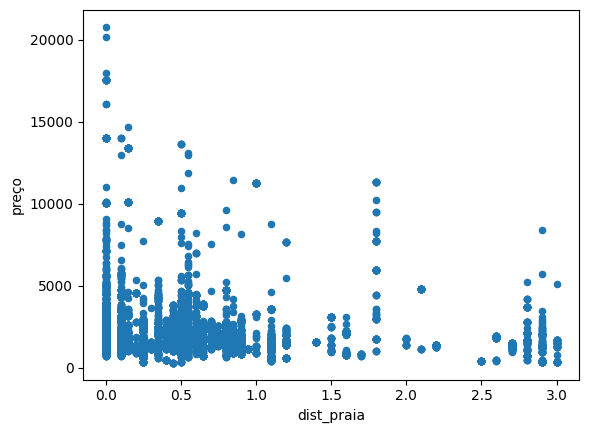

In [60]:
hosp_input.plot.scatter(x='dist_praia',y='preço')

O plot sugere que quanto mais próximo de 0 o valor de dist_praia, o valor do preço potencialmente será maior. Pode servir para uma boa análise, mas apresenta uma quantidade grande de outliers.

<Axes: >

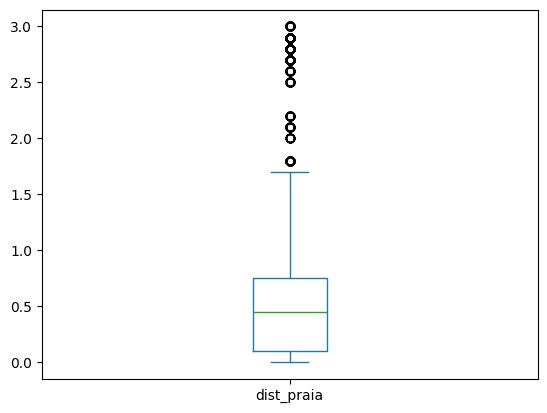

In [61]:
hosp_input['dist_praia'].plot(kind='box')

Com o box plot é possível entender que a maior concentração dos dados está na parte mais baixa, indicando que existem muitos hoteis perto da praia e poucos longe, o que pode não ser uma realidade palpável

In [62]:
hosp_input['dist_praia'].describe()

count    11037.000000
mean         0.580475
std          0.703904
min          0.000000
25%          0.100000
50%          0.450000
75%          0.750000
max          3.000000
Name: dist_praia, dtype: float64

Podemos ver que há uma relação entre preço e distância praia. Se analisarmos bem, percebemos que os dados da dist_praia variam entre 0 e 3 obrigatoriamente, fazendo com que se imagine, que dificilmente os dados que não possuem valor nesta coluna, possuam valores entre o intervalo dito. Basicamente, no Booking.com, o proprietário pode apenas optar por não colocar a distância da praia até a propriedade ou a distância colocada é maior que 3km, então, nesses casos, os valores não aparecem e assim aparecem como dados faltantes. Com isso, não faz sentido aplicar métodos de imputação sobre a coluna dist_praia, pois provavelmente os valores imputados serão entre o intervalo de 0 e 3, sendo possibilidades que podem enviesar e gerar conclusões incorretas. 


Desse modo, foi preferível apagar a coluna dist_praia

In [63]:
hosp_input = hosp_input.drop(columns=['dist_praia'])
# excluindo a coluna checkout por não ser necessária
hosp_input = hosp_input.drop(columns=['checkout'])

Como os dados faltantes representam um percentual um tanto considerável dos dados, foi preferível escolher o método KNN para imputação dos dados. Para isso, vamos primeiro NORMALIZAR os dados para obter um resultado melhor do KNN.

In [64]:
# normalizando os dados

columns_to_normalize = ['preço', 'dist_centro', 'avaliacao', 'qtnd_avaliacoes']
scaler = MinMaxScaler()

hosp_input[columns_to_normalize] = scaler.fit_transform(hosp_input[columns_to_normalize])

print(hosp_input)

       hotel  cidade     preço  checkin  dist_centro  avaliacao  \
0        475       0  0.074051        0     0.088565   0.755556   
1        495       0  0.067001        0     0.050448   0.822222   
2        698       0  0.009822        0     0.000000   0.811111   
3         15       0  0.038168        0     0.011211   0.966667   
4        694       0  0.074148        0     0.076233   0.811111   
...      ...     ...       ...      ...          ...        ...   
15638    458       0  0.126854       46     0.098655   0.000000   
15639    409       0  0.209899       46     0.048206   1.000000   
15640     20       0  0.185054       46     0.091928        NaN   
15641    206       0  0.266884       46     0.849776   0.966667   
15642    226       0  0.535810       46     0.173767        NaN   

       qtnd_avaliacoes  data_extracao  mes_checkin  
0             0.350000              0            7  
1             0.538036              0            7  
2             0.000226              

Aplicando o KNN no dataset normalizado utilizando a biblioteca fancyimpute

In [65]:
# rodando o KNN impute para imputar os dados faltantes
hosp_knn = KNN(k=3).fit_transform(hosp_input)

Imputing row 1/15643 with 0 missing, elapsed time: 39.268
Imputing row 101/15643 with 0 missing, elapsed time: 39.324
Imputing row 201/15643 with 0 missing, elapsed time: 39.368
Imputing row 301/15643 with 0 missing, elapsed time: 39.384
Imputing row 401/15643 with 0 missing, elapsed time: 39.411
Imputing row 501/15643 with 0 missing, elapsed time: 39.438
Imputing row 601/15643 with 0 missing, elapsed time: 39.440
Imputing row 701/15643 with 0 missing, elapsed time: 39.444
Imputing row 801/15643 with 0 missing, elapsed time: 39.458
Imputing row 901/15643 with 2 missing, elapsed time: 39.483
Imputing row 1001/15643 with 0 missing, elapsed time: 39.516
Imputing row 1101/15643 with 0 missing, elapsed time: 39.522
Imputing row 1201/15643 with 0 missing, elapsed time: 39.526
Imputing row 1301/15643 with 0 missing, elapsed time: 39.536
Imputing row 1401/15643 with 0 missing, elapsed time: 39.555
Imputing row 1501/15643 with 0 missing, elapsed time: 39.625
Imputing row 1601/15643 with 0 missi

Após aplicado o KNN, vamos transferir os dados para um novo dataset

In [66]:
hosp2 = pd.DataFrame(data=hosp_knn[0:,0:],columns=['hotel', 'cidade', 'preço', 'checkin', 'dist_centro', 'avaliacao', 'qtnd_avaliacoes', 'data_extracao', 'mes_checkin'])

Revertendo a normalização através da mesma biblioteca

In [67]:
# revertendo a normalização
hosp2[columns_to_normalize] = scaler.inverse_transform(hosp2[columns_to_normalize])

Revendo a correlação entre os dados para comparação

In [68]:
hosp2.corr(method='spearman')

,hotel,cidade,preço,checkin,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
hotel,1.000000,NaN,-0.045768,-0.013961,-0.052071,-0.157552,0.147847,NaN,0.012697
cidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preço,-0.045768,NaN,1.000000,0.092607,0.114370,0.110849,0.029606,NaN,-0.049790
checkin,-0.013961,NaN,0.092607,1.000000,-0.014037,0.027322,-0.090296,NaN,-0.298065
dist_centro,-0.052071,NaN,0.114370,-0.014037,1.000000,-0.027793,0.110995,NaN,0.009141
avaliacao,-0.157552,NaN,0.110849,0.027322,-0.027793,1.000000,-0.231322,NaN,-0.008055
qtnd_avaliacoes,0.147847,NaN,0.029606,-0.090296,0.110995,-0.231322,1.000000,NaN,0.051469
data_extracao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mes_checkin,0.012697,NaN,-0.049790,-0.298065,0.009141,-0.008055,0.051469,NaN,1.000000


Não houve mudanças significativas de diferença entre os valore, indicando que a imputação foi provavelmente bem sucedida

In [69]:
# mediana antiga
hosp_input[columns_to_normalize] = scaler.inverse_transform(hosp_input[columns_to_normalize])
hosp_input.median()

hotel               389.0
cidade                0.0
preço              1638.0
checkin              16.0
dist_centro           6.8
avaliacao             8.6
qtnd_avaliacoes      14.0
data_extracao         0.0
mes_checkin           8.0
dtype: float64

In [70]:
#nova mediana
hosp2.median()

hotel               389.0
cidade                0.0
preço              1638.0
checkin              16.0
dist_centro           6.8
avaliacao             8.7
qtnd_avaliacoes      13.0
data_extracao         0.0
mes_checkin           8.0
dtype: float64

Nas medianas também não houve mudanças significativas

Passando os dados imputados para o dataset original

In [71]:
# passando os dados imputados para o dataset padrao
hospedagens['avaliacao'] = hosp2['avaliacao']
hospedagens['qtnd_avaliacoes'] = hosp2['qtnd_avaliacoes']

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\135721882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['avaliacao'] = hosp2['avaliacao']
C:\Users\extre\AppData\Local\Temp\ipykernel_20172\135721882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['qtnd_avaliacoes'] = hosp2['qtnd_avaliacoes']


Printando se ainda existem valores nulos e garantindo que o processo de imputação foi feito corretamente

In [72]:
hospedagens = hospedagens.drop(columns=['dist_praia'])
print(hospedagens.isnull().sum())


hotel              0
cidade             0
preço              0
checkin            0
checkout           0
dist_centro        0
avaliacao          0
qtnd_avaliacoes    0
data_extracao      0
mes_checkin        0
dtype: int64


## Outliers


Como nosso objetivo é analisar principalmente o preço das hospedagens, vamos focar na remoção de outliers sobre a coluna preço

Removendo primeiro linhas duplicadas com o mesmo checkin, que possuam o mesmo nome de hotel e o mesmo preço.

In [73]:
duplicated_entries = hospedagens[hospedagens.duplicated(subset=['checkin', 'hotel', 'preço'], keep=False)]

# Agrupar e contar ocorrências de duplicatas
duplicated_counts = duplicated_entries.groupby(['checkin', 'hotel', 'preço']).size().reset_index(name='count')

# Filtrar apenas os registros com mais de uma ocorrência
duplicated_counts = duplicated_counts[duplicated_counts['count'] > 1]

# Printar os resultados
print("Hotéis duplicados por mês de check-in:")
print(duplicated_counts)

# Quantidade total de duplicatas
total_duplicates = duplicated_counts['count'].sum()
print("Total de registros duplicados:", total_duplicates)

# Remover as duplicatas do DataFrame original
hospedagens = hospedagens.drop_duplicates(subset=['checkin', 'hotel', 'preço'], keep='first')

Hotéis duplicados por mês de check-in:
          checkin                            hotel  preço  count
732    2024-07-01                           Duplex    714      2
2895   2024-07-08                           Duplex    714      2
4445   2024-07-15  Apartamento Beira Mar em Recife   9450      2
6608   2024-07-22  Apartamento Beira Mar em Recife   9450      2
8771   2024-08-01  Apartamento Beira Mar em Recife   9450      2
...           ...                              ...    ...    ...
95904  2025-06-08                           Duplex    714      2
98067  2025-06-15                           Duplex    714      2
98473  2025-06-15               Flat em Boa Viagem   4760      2
100230 2025-06-22                           Duplex    714      2
100636 2025-06-22               Flat em Boa Viagem   4760      2

[101 rows x 4 columns]
Total de registros duplicados: 202


C:\Users\extre\AppData\Local\Temp\ipykernel_20172\3177665228.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duplicated_counts = duplicated_entries.groupby(['checkin', 'hotel', 'preço']).size().reset_index(name='count')


In [74]:
hospedagens.shape

(15542, 10)

Agora vamos entender a partir de um teste de simetria se os dados são ou não simétricos. O objetivo é descobrir se realmente os dados são assimétricos para assim poder prosseguir corretamente na remoção de outliers

In [75]:
# Teste de D'Agostino
k2, p_value = stats.normaltest(hospedagens['preço'])
print(f"Estatística de teste: {k2}, p-valor: {p_value}")

# Interpretar o resultado
alpha = 0.05
if p_value > alpha:
    print("A distribuição é aproximadamente simétrica.")
else:
    print("A distribuição não é simétrica.")

Estatística de teste: 12721.589754297982, p-valor: 0.0
A distribuição não é simétrica.


O teste acima identificou que a distribuição não é simétrica. Então vamos aplicar log10 no preço para deixar os preços mais simétricos, para assim aplicar o método tukey e identificar os outliers.

<Axes: >

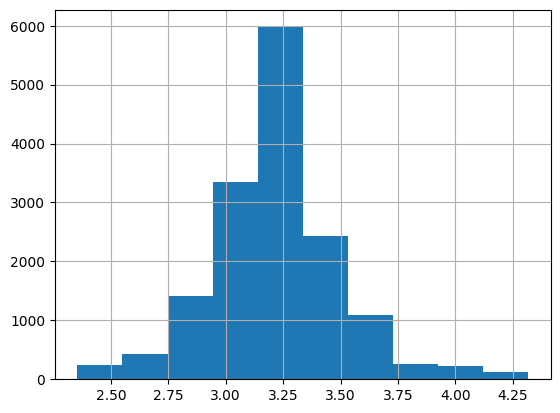

In [76]:
# plotando um histograma com valores normalizados do preço
# como vimos em cima, os dados são assimétricos e é necessário a aplicação do log10 sobre o preço
hospedagens['log_price'] = hospedagens['preço'].apply(np.log10)
hospedagens[hospedagens['log_price'] > 0]['log_price'].hist()

Visualizando o boxplot dos dados para entender mais sobre a quantidade de outliers

<Axes: >

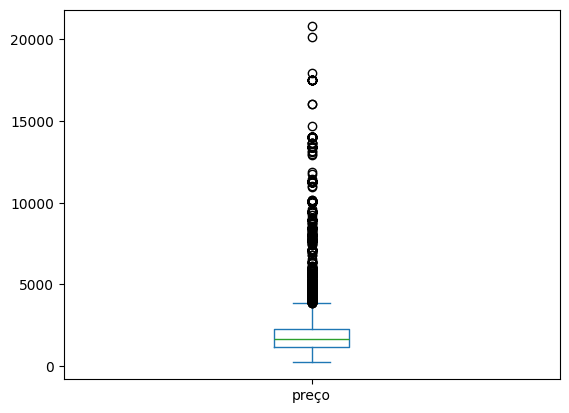

In [77]:
hospedagens[['preço']].plot(kind='box')


Como podemos ver no boxplot, existem uma considerável quantidade de outliers em vários meses do nosso dataset. Como queremos entender as variabilidades do preço durante os meses, se tornou interessante a alternativa de remover os outliers por meses ao invés de remover pelo dataset inteiro.

Resolvemos aplicar o método tukey por ele ser menos sensível a valores extremos, pois a maioria dos outliers que aparecem no boxplot são frutos de acomodações mais luxuosas

Primeiro calculamos o IQR por mês

In [78]:
# calculando o iqr por mês dos preços em log10
grouped = hospedagens.groupby('mes_checkin')['log_price']

q1_per_month = grouped.quantile(0.25)
q3_per_month = grouped.quantile(0.75)

iqr_per_month = q3_per_month - q1_per_month

print('iqr: ', iqr_per_month)

iqr:  mes_checkin
1     0.307016
2     0.341651
3     0.406200
4     0.371278
5     0.366135
6     0.385967
7     0.237284
8     0.234822
9     0.243876
10    0.246672
11    0.249558
12    0.281956
Name: log_price, dtype: float64


Aplicando o tukey

In [79]:
# Aplicar a condição de Tukey ajustada diretamente ao DataFrame original
# Remove os outliers por mês de acordo com seu IQR
hospedagens_clean = hospedagens.groupby('mes_checkin').apply(lambda x: x[
    (x['log_price'] >= (q1_per_month[x.name] - 1.5 * iqr_per_month[x.name])) &
    (x['log_price'] <= (q3_per_month[x.name] + 1.5 * iqr_per_month[x.name]))
]).reset_index(drop=True)

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\1487978861.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hospedagens_clean = hospedagens.groupby('mes_checkin').apply(lambda x: x[


In [80]:
# dataset após a remoção
hospedagens_clean

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.600000,1620.000000,2024-6-6,1,3.142702
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,7.300000,393.000000,2024-6-6,1,2.905796
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,9.100000,14.000000,2024-6-6,1,2.984077
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,10.000000,1.000000,2024-6-6,1,3.007321
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,9.500000,105.000000,2024-6-6,1,3.037825
...,...,...,...,...,...,...,...,...,...,...,...
14594,Apto a beira-mar em Jaboatao dos Guararapes PE,Recife,4128,2024-12-22,2024-12-29,19.4,9.000000,2.000000,2024-6-6,12,3.615740
14595,Hostel da Socorro,Recife,2835,2024-12-22,2024-12-29,9.0,1.000000,1.000000,2024-6-6,12,3.452553
14596,Flat Equipado-Jaqueira Otima Localização-SH032,Recife,4544,2024-12-22,2024-12-29,3.0,8.200000,6.000000,2024-6-6,12,3.657438
14597,Lindo apto à beira-mar Jaboatão dos Guararapes...,Recife,5514,2024-12-22,2024-12-29,16.6,7.000000,1.000000,2024-6-6,12,3.741467


Vamos plotar um histograma dos valores para entender se houve grandes modificações nos valores antes vistos

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\2837122288.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_mediano_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()


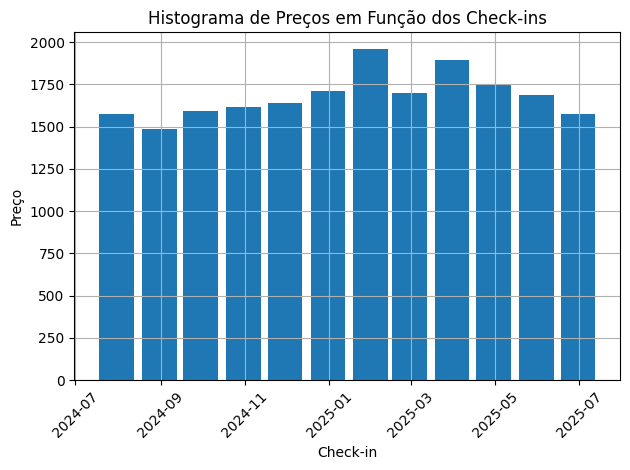

In [81]:
# Plotando o histograma
preco_mediano_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()
plt.bar(preco_mediano_mensal.index, preco_mediano_mensal.values, width=25)
plt.xlabel('Check-in')
plt.ylabel('Preço')
plt.title('Histograma de Preços em Função dos Check-ins')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
# mediana nova dos preços de cada mês
preco_mediano_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()
preco_mediano_mensal

C:\Users\extre\AppData\Local\Temp\ipykernel_20172\1362972130.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_mediano_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].median()


checkin
2024-07-31    1575.0
2024-08-31    1487.0
2024-09-30    1593.0
2024-10-31    1618.0
2024-11-30    1638.0
2024-12-31    1712.0
2025-01-31    1960.0
2025-02-28    1700.0
2025-03-31    1895.0
2025-04-30    1747.0
2025-05-31    1687.0
2025-06-30    1575.0
Freq: ME, Name: preço, dtype: float64

É possível notar algumas mudanças nesses dados em comparação com o dataset antes da remoção, mas a variação nos dados por mês permanece, inclusive ainda há uma "alta" variação nos meses de janeiro e março, meses que possuem épocas festivas. 

<Axes: >

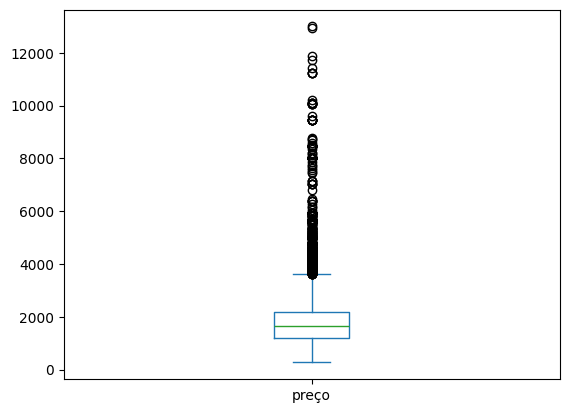

In [83]:
hospedagens_clean['preço'].plot(kind='box')

In [84]:
hospedagens_clean.describe()

,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,mes_checkin,log_price
count,14599.000000,14599,14599,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000
mean,1873.288376,2024-11-16 02:45:30.762380800,2024-11-23 02:45:30.762381056,8.236718,8.268823,421.855752,7.390027,3.215519
min,268.000000,2024-07-01 00:00:00,2024-07-08 00:00:00,0.200000,1.000000,1.000000,1.000000,2.428135
25%,1190.000000,2024-08-22 00:00:00,2024-08-29 00:00:00,4.400000,7.700000,3.000000,5.000000,3.075547
50%,1638.000000,2024-11-01 00:00:00,2024-11-08 00:00:00,6.800000,8.700000,13.000000,8.000000,3.214314
75%,2165.000000,2025-01-22 00:00:00,2025-01-29 00:00:00,9.500000,9.500000,82.000000,10.000000,3.335458
max,13000.000000,2025-06-22 00:00:00,2025-06-29 00:00:00,89.400000,10.000001,8861.000000,12.000000,4.113943
std,1082.378529,NaN,NaN,7.009025,1.885859,1119.919483,3.257766,0.218999


Apesar de o gráfico ainda, aparentemente, apresentar outliers, muitos foram removidos e houve um ajuste significativo.

## Discretização

Decidimos discretizar as colunas principais da nossa análise: Preço e Mes_checkin.
Discretizamos preço para gerar categorias de preço, variando de econômico até muito caro. Esse é um bom jeito para visualizar oportunidades, podendo filtrar os dados pela tag "econômico" para visualizar boas oportunidades de preço.
E, também, aplicamos categorias de estações do ano através da discretização, para assim ficar mais fácil a visualização futura de insights sobre estações do ano e sua variabilidade no preço.

In [85]:
# Discretizar a coluna de preços em 5 categorias
hospedagens_clean['price_category'] = pd.qcut(hospedagens_clean['preço'], 5, labels=['Econômico', 'Baixo', 'Médio', 'Caro', 'Muito Caro'])


In [86]:
hospedagens_clean.head()

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,price_category
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.6,1620.0,2024-6-6,1,3.142702,Baixo
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,7.3,393.0,2024-6-6,1,2.905796,Econômico
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,9.1,14.0,2024-6-6,1,2.984077,Econômico
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,10.0,1.0,2024-6-6,1,3.007321,Econômico
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,9.5,105.0,2024-6-6,1,3.037825,Econômico


In [87]:
# Definir a função para mapear os meses para as estações do ano
def month_to_season(month):
    if month in [9, 10, 11]:
        return 'Primavera'
    elif month in [12, 1, 2]:
        return 'Verão'
    elif month in [3, 4, 5]:
        return 'Outono'
    else:
        return 'Inverno'

# Discretizar os meses e adicionar categorias de estações do ano
hospedagens_clean['season'] = hospedagens_clean['mes_checkin'].apply(month_to_season)
hospedagens_clean.head(10)

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,price_category,season
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.6,1620.0,2024-6-6,1,3.142702,Baixo,Verão
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,7.3,393.0,2024-6-6,1,2.905796,Econômico,Verão
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,9.1,14.0,2024-6-6,1,2.984077,Econômico,Verão
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,10.0,1.0,2024-6-6,1,3.007321,Econômico,Verão
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,9.5,105.0,2024-6-6,1,3.037825,Econômico,Verão
5,Bonito é ser Feliz,Recife,684,2025-01-01,2025-01-08,4.8,9.8,46.0,2024-6-6,1,2.835056,Econômico,Verão
6,Park Hotel,Recife,2684,2025-01-01,2025-01-08,8.6,8.5,5064.0,2024-6-6,1,3.428783,Muito Caro,Verão
7,Rede Andrade LG Inn,Recife,1827,2025-01-01,2025-01-08,6.8,7.7,8861.0,2024-6-6,1,3.261739,Caro,Verão
8,Qto Duplo próximo ao Shopping Recife,Recife,625,2025-01-01,2025-01-08,8.1,10.0,3.0,2024-6-6,1,2.795880,Econômico,Verão
9,Hotel Pousada Casa Grande,Recife,1190,2025-01-01,2025-01-08,11.5,8.0,2.0,2024-6-6,1,3.075547,Baixo,Verão


plotando as medianas do preço de cada estação

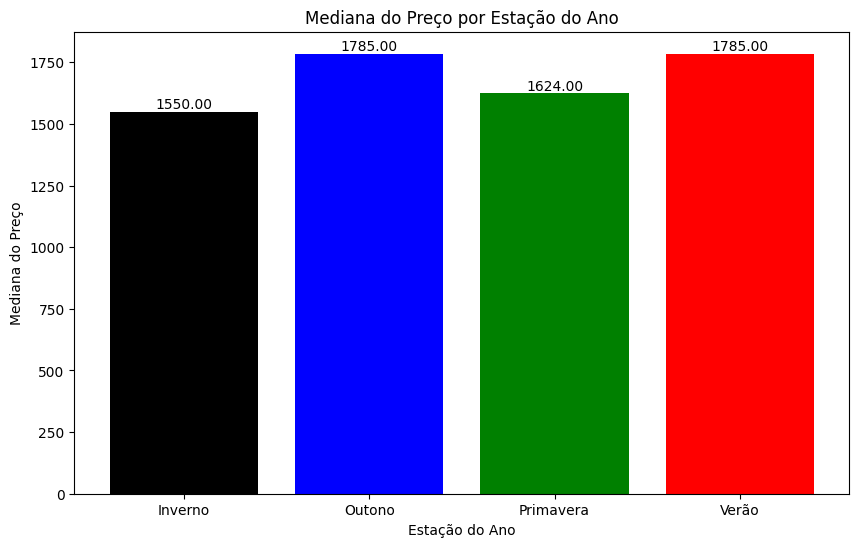

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a mediana dos preços para cada estação do ano
median_prices_season = hospedagens_clean.groupby('season')['preço'].median()

# Obter os valores das medianas e as estações do ano
seasons = median_prices_season.index
medians = median_prices_season.values

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(seasons, medians, color=['black', 'blue', 'green', 'red'])

# Adicionar os valores das medianas acima das barras
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom')

# Adicionar legendas e título
plt.xlabel('Estação do Ano')
plt.ylabel('Mediana do Preço')
plt.title('Mediana do Preço por Estação do Ano')

# Exibir o gráfico
plt.show()


O outono e inverno se destacam. O outono provavelmente por causa do carnaval e o verão por dezembro e janeiro (fim de ano)

In [89]:
# printando as hospedagens no mês de dezembro (verão)
hospedagens_clean[hospedagens_clean['mes_checkin'] == 12].head()

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,price_category,season
13353,Hotel Golden Park Recife Boa Viagem,Recife,1722,2024-12-01,2024-12-08,9.3,7.5,2655.0,2024-6-6,12,3.236033,Médio,Verão
13354,Transamerica Fit Recife,Recife,1648,2024-12-01,2024-12-08,7.0,8.3,5177.0,2024-6-6,12,3.216957,Médio,Verão
13355,Aconchegante Apto de 1qt a 60mts do Consulado EUA,Recife,1011,2024-12-01,2024-12-08,1.2,9.7,36.0,2024-6-6,12,3.004751,Econômico,Verão
13356,Park Hotel,Recife,2095,2024-12-01,2024-12-08,8.6,8.5,5064.0,2024-6-6,12,3.321184,Caro,Verão
13357,Hotel Central,Recife,805,2024-12-01,2024-12-08,0.8,7.3,393.0,2024-6-6,12,2.905796,Econômico,Verão


In [90]:
# printando as hospedagens com preço baixo
hospedagens_clean[hospedagens_clean['price_category'] == 'Baixo']

,hotel,cidade,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin,log_price,price_category,season
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,8.600000,1620.000000,2024-6-6,1,3.142702,Baixo,Verão
9,Hotel Pousada Casa Grande,Recife,1190,2025-01-01,2025-01-08,11.5,8.000000,2.000000,2024-6-6,1,3.075547,Baixo,Verão
25,ibis budget Recife Jaboatão,Recife,1265,2025-01-01,2025-01-08,12.7,8.400000,2077.000000,2024-6-6,1,3.102091,Baixo,Verão
34,Pousada Nordestina,Recife,1260,2025-01-01,2025-01-08,14.1,7.300000,253.000000,2024-6-6,1,3.100371,Baixo,Verão
46,Espaço inteiro a beira mar,Recife,1428,2025-01-01,2025-01-08,7.0,10.000000,2.000000,2024-6-6,1,3.154728,Baixo,Verão
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14529,Pousada Shalom,Recife,1190,2024-12-22,2024-12-29,4.8,7.201257,341.754484,2024-6-6,12,3.075547,Baixo,Verão
14530,Aurora Recife Hostel,Recife,1176,2024-12-22,2024-12-29,1.1,8.965950,574.734345,2024-6-6,12,3.070407,Baixo,Verão
14545,Quarto Litoral Sul,Recife,1418,2024-12-22,2024-12-29,4.5,1.000000,1.000000,2024-6-6,12,3.151676,Baixo,Verão
14571,Bugan Paiva flatpaivahome,Recife,1386,2024-12-22,2024-12-29,19.6,8.000000,5.000000,2024-6-6,12,3.141763,Baixo,Verão



## Normalização <a id="#normalização"></a>

Normalizando o preço entre 0 e 1

In [91]:
#preço está dominando o cálculo
dist = np.linalg.norm(hospedagens_clean[['preço', 'dist_centro', 'avaliacao', 'qtnd_avaliacoes']].values[1]-hospedagens_clean[['preço', 'dist_centro', 'avaliacao', 'qtnd_avaliacoes']].values[2])
print(dist)

411.0754188710388


In [92]:
# normalizando o preço
scaler = MinMaxScaler()

hospedagens_clean["norm_price"] = scaler.fit_transform(hospedagens_clean[['preço']])

hospedagens_clean.describe()

,preço,checkin,checkout,dist_centro,avaliacao,qtnd_avaliacoes,mes_checkin,log_price,norm_price
count,14599.000000,14599,14599,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000,14599.000000
mean,1873.288376,2024-11-16 02:45:30.762380800,2024-11-23 02:45:30.762381056,8.236718,8.268823,421.855752,7.390027,3.215519,0.126083
min,268.000000,2024-07-01 00:00:00,2024-07-08 00:00:00,0.200000,1.000000,1.000000,1.000000,2.428135,0.000000
25%,1190.000000,2024-08-22 00:00:00,2024-08-29 00:00:00,4.400000,7.700000,3.000000,5.000000,3.075547,0.072416
50%,1638.000000,2024-11-01 00:00:00,2024-11-08 00:00:00,6.800000,8.700000,13.000000,8.000000,3.214314,0.107603
75%,2165.000000,2025-01-22 00:00:00,2025-01-29 00:00:00,9.500000,9.500000,82.000000,10.000000,3.335458,0.148995
max,13000.000000,2025-06-22 00:00:00,2025-06-29 00:00:00,89.400000,10.000001,8861.000000,12.000000,4.113943,1.000000
std,1082.378529,NaN,NaN,7.009025,1.885859,1119.919483,3.257766,0.218999,0.085012


## Teste de hipótese

Existe uma variação significativa nos preços que possa indicar uma alta e baixa temporada no local?


Para isso, utilizamos o teste de hipótese 'Kruskal-Wallis' pois:

- Assume variáveis não paramétricas: Nossa distribuição não é simétrica.
- Compara 3 ou mais grupos: Por estar separado por meses, precisávamos de um teste que pudesse ser aplicado para todos os 12 grupos
- Compara grupos distintos: Os dados de cada mês são diferentes uns dos outros

Hipótese Nula (H0): Os preços dos hotéis não variam significativamente entre os meses.

Hipótese Alternativa (HA): Os preços dos hotéis variam significativamente entre os meses

Primeiro  vamos fazer um teste de hipótese para entender se os dados são realmente assimétricos

In [93]:
stat, p = shapiro(hospedagens_clean[['preço']])
print(f'Estatística do teste de Shapiro-Wilk: {stat}, p-valor: {p}')
if p > 0.05:
    print(f'A amostra de preço parece vir de uma distribuição normal (não rejeita H0)')
else:
    print(f'A amostra de preço não parece vir de uma distribuição normal (rejeita H0)')

Estatística do teste de Shapiro-Wilk: 0.8134712371890271, p-valor: 1.0891939474070623e-83
A amostra de preço não parece vir de uma distribuição normal (rejeita H0)


c:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14599.
  res = hypotest_fun_out(*samples, **kwds)


Sabendo que temos dados assimétricos (o que explica os gráficos que fogem de uma normal) vamos realizar o teste kruskal-wallis para comparar os preços entre os meses.

In [94]:

# Filtrar dados por mês
grouped = hospedagens_clean.groupby('mes_checkin')['preço'].apply(list)

# Realizar Kruskal-Wallis
h_statistic, p_value = kruskal(*grouped)

print(f"Kruskal-Wallis H-Statistic: {h_statistic}, p-value: {p_value}")

# Verificar resultado
if p_value < 0.01:
    print("Rejeitamos a hipótese nula: Existe uma variação significativa nos preços entre os meses.")
else:
    print("Falhamos em rejeitar a hipótese nula: Não existe uma variação significativa nos preços entre os meses.")


Kruskal-Wallis H-Statistic: 285.90615959231144, p-value: 8.120275671582972e-55
Rejeitamos a hipótese nula: Existe uma variação significativa nos preços entre os meses.


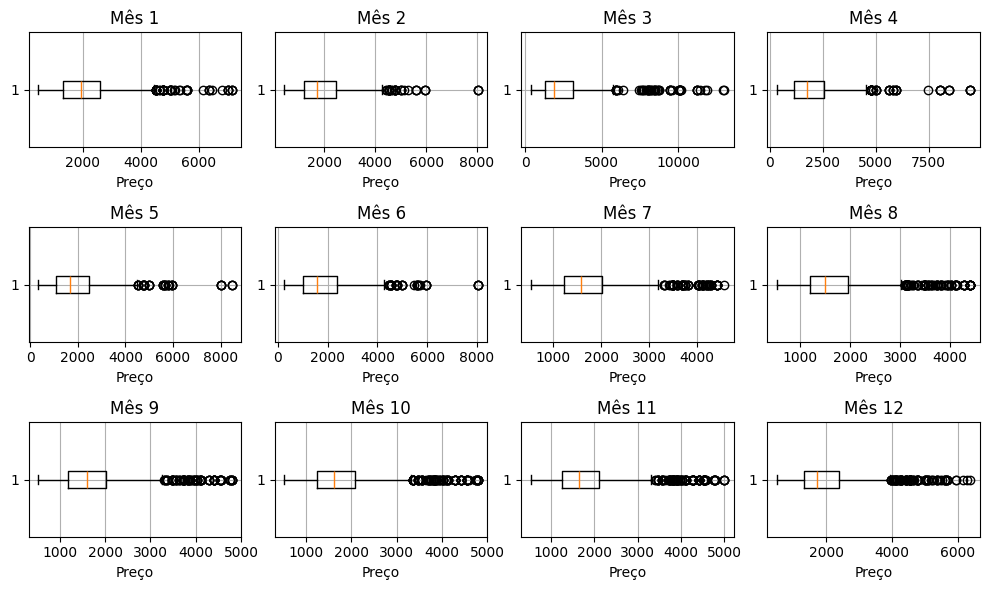

In [95]:
# Criar uma figura para os boxplots
plt.figure(figsize=(10, 6))

# Iterar sobre os meses e criar um boxplot para cada mês
for month in range(1, 13):
    data_month = hospedagens_clean[hospedagens_clean['mes_checkin'] == month]
    plt.subplot(3, 4, month)
    plt.boxplot(data_month['preço'], vert=False)
    plt.title(f'Mês {month}')
    plt.xlabel('Preço')
    plt.grid(True)

plt.tight_layout()
plt.show()

Com isso, percebemos, que sim, os dados possuem uma certa variação de preço entre os meses, indicando que possivelmente há a presença de períodos de alta ou baixa temporada.

Vamos agora comparar dois meses para entender se há variação entre eles ou não

Escolhemos os meses de março (possui o carnaval e assim teoricamente a demanadae preço aumentariam) e julho (férias de inverno e menos procura por praias pela cidade estar com um clima predominantemente nublado)

Como são dois grupos distintos, vamos usar um teste de hipótese de par. 

Hipótese nula (H0): Não há diferença significativa nos preços de hospedagem entre março e junho.

Hipótese alternativa(H1): Há uma diferença significativa nos preços de hospedagem entre março e junho.

In [96]:
from scipy.stats import mannwhitneyu

# Suponha que você queira comparar os preços de janeiro (mês 1) com os preços de fevereiro (mês 2)
preços_março = hospedagens_clean[hospedagens_clean['mes_checkin'] == 3]['preço']
preços_junho = hospedagens_clean[hospedagens_clean['mes_checkin'] == 6]['preço']

# Realize o teste de Mann-Whitney
statistic, p_value = mannwhitneyu(preços_março, preços_junho)

print("Estatística do teste U de Mann-Whitney:", statistic)
print("Valor-p:", p_value)
# Exiba os resultados
if p_value > 0.01:
    print("Falha em rejeitar a hipótese nula (H0): Não há diferença significativa nos preços de hospedagem entre março e junho.")
else:
    print("Rejeição da hipótese nula (H0): Há uma diferença significativa nos preços de hospedagem entre março e junho.")

Estatística do teste U de Mann-Whitney: 311092.0
Valor-p: 3.1250972292004095e-11
Rejeição da hipótese nula (H0): Há uma diferença significativa nos preços de hospedagem entre março e junho.


O teste indica que há uma diferença estatisticamente significativa nos preços de hospedagem entre esses dois meses. Portanto, podemos concluir que os preços de hospedagem em março são significativamente diferentes dos preços em junho, possivelmente devido a presença do carnaval no mês de março, gerando mais demanda.

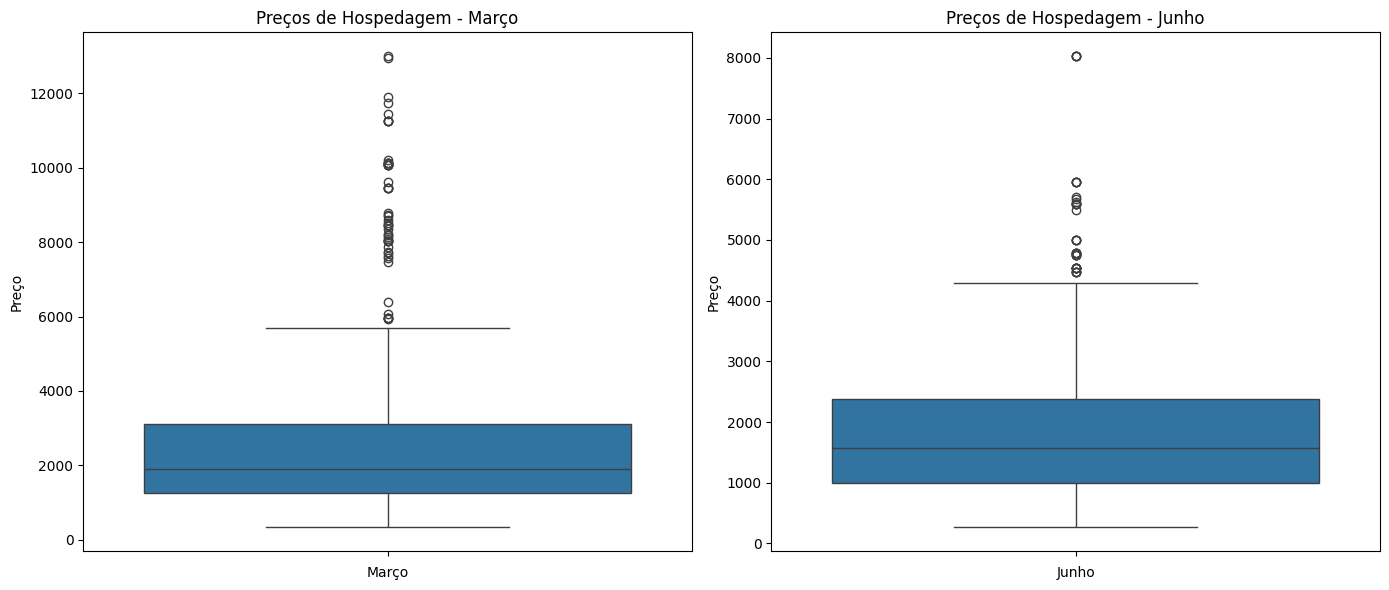

In [97]:
import seaborn as sns
# Filtrar os dados para os meses de março (mês 3) e junho (mês 6)
dados_março = hospedagens_clean[hospedagens_clean['mes_checkin'] == 3]
dados_junho = hospedagens_clean[hospedagens_clean['mes_checkin'] == 6]

# Criar a figura e os eixos para os dois boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot para março
sns.boxplot(y='preço', data=dados_março, ax=axes[0])
axes[0].set_title('Preços de Hospedagem - Março')
axes[0].set_xlabel('Março')
axes[0].set_ylabel('Preço')

# Boxplot para junho
sns.boxplot(y='preço', data=dados_junho, ax=axes[1])
axes[1].set_title('Preços de Hospedagem - Junho')
axes[1].set_xlabel('Junho')
axes[1].set_ylabel('Preço')

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()


Apesar de primeira olhada o mês de junho parecer maior, os valores do eixo y demonstram maiores valores e uma mediana maior no mês de março, indicando que esse mês é o mais procurado, provavelmente por causa do carnaval.